In [2]:
# Import libraries
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# for high-res images export
# from IPython import display
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import os
import uuid

In [15]:
# Style
rcParams['font.weight'] = 'bold'
sns.set_palette("GnBu_d")

In [3]:
FOLDER = 'figures'
if not os.path.isdir(FOLDER):
    os.makedirs(FOLDER)
    
LATEX_FILE_NAME = 'figures.txt'

In [8]:
# cd results
cd_sp_raw = [0.39, 0.47, 0.48, 0.48]
cd_sp_reph = [0.45, 0.48, 0.46, 0.44]
cd_sp_raw_ft = [0.88, 0.9, 0.9, 0.9]
cd_sp_reph_ft = [0.92, 0.93, 0.94, 0.94]
cd_ss_raw = [0.30, 0.26, 0.38, 0.42]
cd_ss_reph = [0.26, 0.26, 0.37, 0.42]
cd_ss_raw_ft = [0.91, 0.91, 0.90, 0.92]
cd_ss_reph_ft = [0.91, 0.91, 0.90, 0.85]

In [9]:
# ec results
ec_sp_raw = [0.35, 0.20, 0.28, 0.28]
ec_sp_reph = [0.26, 0.57, 0.46, 0.50]
ec_sp_raw_ft = [0.85, 0.82, 0.80, 0.80]
ec_sp_reph_ft = [0.84, 0.82, 0.81, 0.82]
ec_ss_raw = [0.47, 0.49, 0.48, 0.49]
ec_ss_reph = [0.38, 0.44, 0.49, 0.43]
ec_ss_raw_ft = [0.89, 0.88, 0.85, 0.84]
ec_ss_reph_ft = [0.85, 0.85, 0.84, 0.86]

In [10]:
# cs results
cs_sp_raw = [0.36, 0.24, 0.30, 0.30]
cs_sp_reph = [0.22, 0.26, 0.29, 0.27]
cs_sp_raw_ft = [0.70, 0.73, 0.72, 0.71]
cs_sp_reph_ft = [0.71, 0.71, 0.71, 0.68]
cs_ss_raw = [0.17, 0.23, 0.23, 0.25]
cs_ss_reph = [0.16, 0.15, 0.13, 0.18]
cs_ss_raw_ft = [0.7, 0.72, 0.75, 0.72]
cs_ss_reph_ft = [0.71, 0.73, 0.72, 0.72]

In [4]:
# epochs
epochs = [1, 2, 3, 4]

In [11]:
# lists of lists for columns
columns = [
    epochs,
    cd_sp_raw,
    cd_sp_reph,
    cd_sp_raw_ft,
    cd_sp_reph_ft,

    cd_ss_raw,
    cd_ss_raw_ft,
    cd_ss_reph,
    cd_ss_reph_ft,

    ec_sp_raw,
    ec_sp_reph,
    ec_sp_raw_ft,
    ec_sp_reph_ft,

    ec_ss_raw,
    ec_ss_raw_ft,
    ec_ss_reph,
    ec_ss_reph_ft,

    cs_sp_raw,
    cs_sp_reph,
    cs_sp_raw_ft,
    cs_sp_reph_ft,
    
    cs_ss_raw,
    cs_ss_raw_ft,
    cs_ss_reph,
    cs_ss_reph_ft
]

In [21]:
def generate_latex_figure(path, caption, label):
    '''
    Generates figure in Latex format
    '''
    caption = caption.replace('_', '\_') # Latex!

    return r'\begin{figure}[ht!]' + \
        '\n\t' + \
        r'\centering' + \
        '\n\t' + \
        r'\includesvg[width=\columnwidth]{' + \
        f'{path}' + \
        r'}' + \
        '\n\t' + \
        r'\caption{' + \
        f'{caption}' + \
        r'}' + \
        '\n\t' + \
        r'\label{' + \
        f'{label}' + \
        r'}' + \
        '\n' + \
        r'\end{figure}' + \
        '\n\n'
    
def write_latex_to_file(figs_desc, file_name):
    '''
    Exports latex to a .txt file
    '''

    with open(file_name, "a") as myfile:
        for fd in figs_desc:
            myfile.write(generate_latex_figure(path=fd['path'], caption=fd['caption'], label=fd['label']))

    myfile.close()

In [13]:
# get names of variables for indexing
def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None
column_names = [get_variable_name(list) for list in columns]

In [18]:
# push data to dataframe and use column names as rows to pivot
df = pd.DataFrame(columns, index=column_names).T

In [14]:
TASKS = [
    {
        'code': 'cd',
        'name': 'CLIMATE DETECTION',
        'classes': ['NO', 'YES'],
        'class_distr': [393, 1307] 
    },
    {
        'code': 'ec',
        'name': 'ENVIRONMENTAL CLAIMS',
        'classes': ['NO', 'YES'],
        'class_distr': [1983, 664] 
    },
    {
        'code': 'cs',
        'name': 'CLIMATE SENTIMENT',
        'classes': ['NEUTRAL', 'RISK', 'OPPORTUNITY'],
        'class_distr': [538, 451, 331],  
    }
]

DATASETS = [
    {
        'code': 'sp',
        'name': 'SlimPajama',
    },
    {
        'code': 'ss',
        'name': 'SemanticScholar',
    }
]

In [15]:
def get_fig_dict(file_name):
    return {
        'path': f'{FOLDER}/{file_name}',
        'label': f'fig:{FOLDER}__{file_name}'
    }

In [16]:
def plot_perf_per_epoch(task):
    cols_to_plot = ['raw', 'reph', 'raw_ft', 'reph_ft']
    colors = ["#FF8400", "#4374B3"]
    fig, axs = plt.subplots(nrows=len(DATASETS), ncols=1, sharex=True, figsize=(6, 4)) # 10, 2 for sharey=True
    for idx, ds in enumerate(DATASETS):
        best_f1_score = -1
        best_epoch    = -1
        pref = f"{task['code']}_{ds['code']}_"
        for col in cols_to_plot:
            # Plot
            col_name = f"{pref}{col}"
            sns.lineplot(ax=axs[idx], x=df['epochs'], y=df[col_name], label=col, linewidth=1.5, color=colors[0 if col.startswith('raw') else 1])

            if max(df[col_name]) > best_f1_score:
                best_f1_score = max(df[col_name])
                best_epoch = np.argmax(df[col_name]) + 1
            # Style
            axs[idx].spines[['right', 'top']].set_visible(False)

            # Axis labels
            axs[idx].set_xticks(df['epochs'])
            axs[idx].set_xlabel('epochs', fontdict={'weight': 'bold'})
            axs[idx].set_ylabel('F1 score', fontdict={'weight': 'bold'})


        # Dashed lines for not fine-tuned results
        axs[idx].lines[0].set_linestyle("--")
        axs[idx].lines[1].set_linestyle("--")

        # Style
        axs[idx].grid(True)

        # Title
        axs[idx].set_title(ds['name'], fontdict={'weight': 'bold', 'fontsize': 10}) #, pad=10)

        # Mark the best epoch
        axs[idx].plot([best_epoch] * 2, [axs[idx].get_ylim()[0] * 0.9, best_f1_score], linestyle="-.", color='g', marker="x", markeredgewidth=2, ms=5, label=f"best score")

        # Shrink current axis by 20%
        box = axs[idx].get_position()
        axs[idx].set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        axs[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)



    # fig.tight_layout()

    # Figure main title
    plt.suptitle(task['name'].upper(), fontsize=11, fontweight='bold') #, y=1.15)
   
    # Export figure setup
    _id = uuid.uuid4().hex[:6].upper()

    file_name = f"F1_score_{task['code']}.svg"

    file_name = f"{file_name.split('.')[0]}__{_id}.svg"

    plt.savefig(f"./{FOLDER}/{file_name}") 

    return {**get_fig_dict(file_name=file_name), 
            'caption': f"F1 score (macro avg)"}

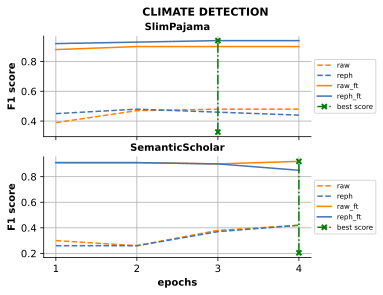

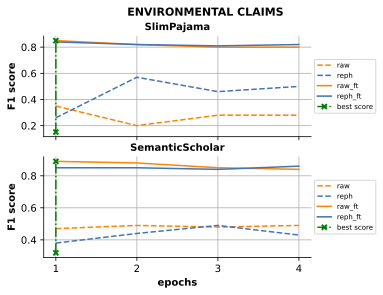

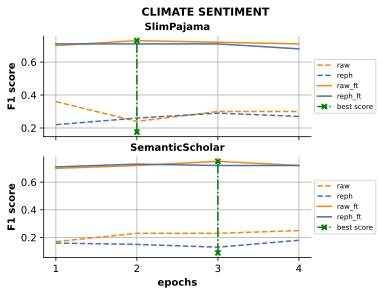

In [22]:
figs_desc_list = []

for task in TASKS:
    desc = plot_perf_per_epoch(task=task)
    figs_desc_list.append(desc)

In [23]:
write_latex_to_file(figs_desc=figs_desc_list, file_name=LATEX_FILE_NAME)

In [24]:
import json

def plot_abstact_length_distribution(file_name):
    _, ax = plt.subplots(figsize=(8, 6))

    plt.rcParams['patch.linewidth'] = 0.75
    plt.rcParams['patch.edgecolor'] = 'white'
    sns.set_palette("tab10")
    # sns.set_palette("GnBu_d")
    
    abstract_lengths = []

    with open(file_name) as f:
        abstract_lengths = [len(json.loads(line)['abstract' if file_name.startswith('SS') else 'text'].split(' ')) for line in f]

    short = sum(i <=300 for i in abstract_lengths)

    dataset = 'Semantic Scholar' if file_name.startswith('SS') else 'SlimPajama'

    print(f"Less than 300 words for dataset {dataset}: {short} {100 * short / len(abstract_lengths)}")
    
    sns.histplot(abstract_lengths, bins=50)
    # sns.histplot(ax=ax, x=x, binwidth=0.25, discrete=discrete)
    
    # style
    ax.set(xlabel="", ylabel="")
    # ax.set_xlim(right=int(max(x)) * 1.1)  # adjust xlim to fit labels
    ax.spines[['right', 'top']].set_visible(False)
    
    # title
    ax.set_title(f'Distribution of abstact lengths for {dataset} dataset', fontdict={'weight': 'bold', 'fontsize': 13})

    plt.grid(True)
        
    file_name = f'distribution_{dataset}.svg'

    _id = uuid.uuid4().hex[:6].upper()

    file_name = f"{file_name.split('.')[0]}__{_id}.svg"

    plt.savefig(f"./{FOLDER}/{file_name}")

    return {**get_fig_dict(file_name=file_name), 'caption': f'Distribution of abstact lengths for {dataset}'}

Less than 300 words for dataset Semantic Scholar: 1784387 84.49062116021562
Less than 300 words for dataset SlimPajama: 33 15.492957746478874


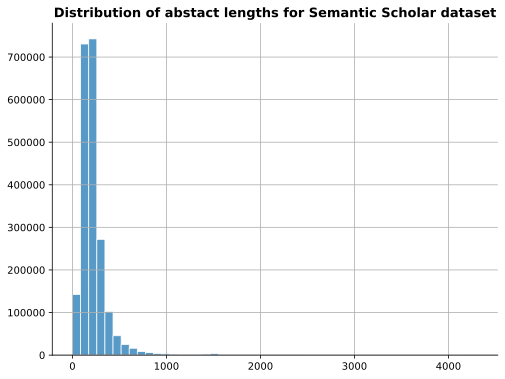

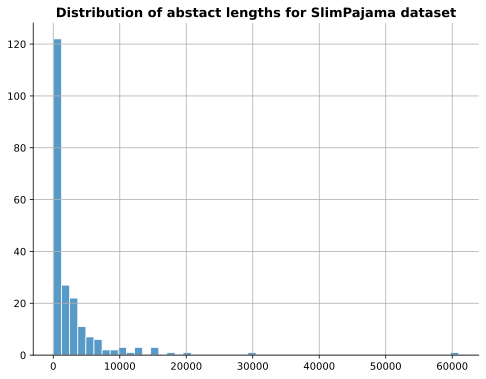

In [25]:
figs_desc_list = []

# Semantic Scholar -> Adjust the path to the dataset
desc = plot_abstact_length_distribution(file_name='SS_dataset.jsonl')
figs_desc_list.append(desc)

# SlimPajama ->  Adjust the path to the dataset
desc = plot_abstact_length_distribution(file_name='SP_dataset.json')
figs_desc_list.append(desc)

In [26]:
write_latex_to_file(figs_desc=figs_desc_list, file_name=LATEX_FILE_NAME)

In [27]:
def h_barchart(ax, x, y, title, total=None, title_font_size=12, feature_importance=False, negative_x_lim=False):
    '''
    Creates and styles horizontal bar chart where labels are counts and corresponding percentages
    In some use cases total is not 'sum(x)' (e.g. for the missing values plot) so we allow passing it indenpendently
    '''
    # labels
    if total is None:
        total = sum(x)

    perc = 0
    if feature_importance and negative_x_lim: # last minute fix, limit it only to SVM coeff case
        perc = list(np.abs(100 * np.array(x)))
    else:
        perc = list(100 * np.array(x) / total) # np.array, so we can use element-wise operation for computing percentages

    labels = []
    for c, p in zip(x, perc):
        labels.append(f"{c} [{p:.2f}%]" if feature_importance == False else f"{c:.4f} [{p:.2f}%]")

    # plot
    sns.barplot(ax=ax, x=x, y=list(map(str, y)), width=0.5) # mapping to str needed for target column

    if feature_importance == False:
        ax.set_xlim(right=int(max(x) * 1.2))  # adjust xlim to fit labels
    else:
        if negative_x_lim:
            ax.set_xlim(right=max(x) * 1.5, left=min(x) * 500) # dirty fix

    # style
    ax.bar_label(ax.containers[0], labels=labels, padding=5, fontweight='bold')
    ax.spines[['right', 'top', 'bottom']].set_visible(False) # only 'left' border is visible
    ax.xaxis.set_visible(False) # remove x axis, information is contained in the label

    # title
    ax.set_title(title, fontdict={'weight': 'bold', 'fontsize': title_font_size})

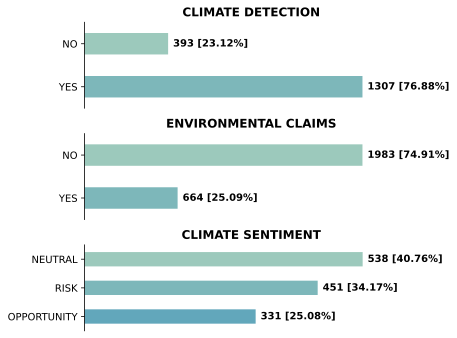

In [28]:
figs_desc_list = []

sns.set_palette("GnBu_d")
fig, axs = plt.subplots(nrows=3, ncols=1)

for idx, task in enumerate(TASKS):
    h_barchart(ax=axs[idx], x=list(task['class_distr']), y=list(task['classes']), title=task['name'])

_id = uuid.uuid4().hex[:6].upper()

file_name = f"class_distributions.svg"

file_name = f"{file_name.split('.')[0]}__{_id}.svg"

plt.savefig(f"./{FOLDER}/{file_name}") 

fig.tight_layout()

figs_desc_list.append({**get_fig_dict(file_name=file_name), 'caption': f"Class distributions"})

In [29]:
write_latex_to_file(figs_desc=figs_desc_list, file_name=LATEX_FILE_NAME)